<a href="https://colab.research.google.com/github/GuyWhoCodesThings/NLP-projects/blob/main/Emotion_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from matplotlib import pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn import preprocessing
from keras.utils.np_utils import to_categorical  
from tensorflow.keras import layers
from tensorflow.keras import losses
from sklearn import preprocessing

https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp?select=val.txt

In [173]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

In [3]:
with open('/content/drive/MyDrive/KaggleDatasets/train.txt') as f:
    contents = f.readlines()

In [4]:
split_txt = []
for i in range (len(contents)):
  split_txt.append(contents[i].split(';'))

In [5]:
sentences = []
emotions = []
for i in range (len(contents)):
  sentences.append(split_txt[i][0])
  emotions.append(split_txt[i][1])

In [6]:
labels = np.array(emotions)
labels = labels.astype('str')
unique_labels = np.unique(labels)
print(unique_labels)

['anger\n' 'fear\n' 'joy\n' 'love\n' 'sadness\n' 'surprise\n']


In [7]:
label_dict = {
    'anger\n':0,
    'fear\n':1,
    'joy\n':2,
    'love\n':3,
    'sadness\n':4,
    'surprise\n':5
}

In [8]:
#get labels from string to int
int_labels = []
for i in range(len(labels)):
  int_labels.append(label_dict[labels[i]])

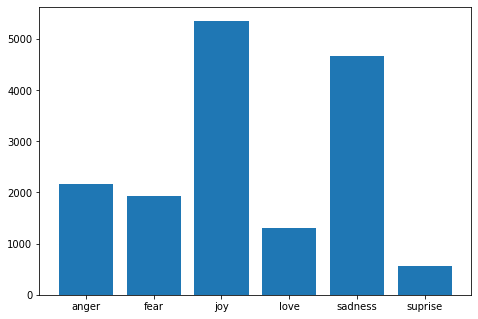

In [161]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
names = ['anger', 'fear', 'joy', 'love', 'sadness', 'suprise']
anger = int_labels.count(0)
fear = int_labels.count(1)
joy = int_labels.count(2)
love = int_labels.count(3)
sadness = int_labels.count(4)
suprise = int_labels.count(5)
amount = [anger, fear, joy, love, sadness, suprise]
ax.bar(names,amount)
plt.show()

In [9]:
catagorical_labels = np.array(to_categorical(int_labels, num_classes = (len(unique_labels))))
sentences=np.array(sentences)

In [10]:
def split_data(input, train_split=0.8, val_split=0.1):
  length = len(input)
  train = input[:int(length*train_split)]
  val = input[int(length*train_split):int(length*val_split + length*train_split)]
  test = input[int(length*val_split + length*train_split):]
  return train, val, test


In [11]:
len(sentences)

16000

In [12]:
x_train, x_val, x_test = split_data(sentences, train_split=0.9, val_split=0.05)
y_train, y_val, y_test = split_data(catagorical_labels, train_split=0.9, val_split=0.05)

In [13]:
tokenizer = Tokenizer(num_words=500, oov_token = "<00V>")
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(x_train)
training_padded = pad_sequences(training_sequences, padding='post')
val_sequences = tokenizer.texts_to_sequences(x_val)
val_padded = pad_sequences(val_sequences, padding='post', maxlen=training_padded.shape[-1])
test_sequences = tokenizer.texts_to_sequences(x_test)
test_padded = pad_sequences(test_sequences, padding='post', maxlen=training_padded.shape[-1])

In [14]:
print(training_padded.shape)
print(val_padded.shape)
print(test_padded.shape)

(14400, 66)
(800, 66)
(800, 66)


In [15]:
print(training_padded[0])

[  2 134   3   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0]


In [16]:
y_train.shape

(14400, 6)

In [17]:
print("num of vocab words in training are: ", len(word_index))

num of vocab words in training are:  14422


In [18]:
print('x shape: ', training_padded.shape)
print('y shape: ', y_train.shape)

x shape:  (14400, 66)
y shape:  (14400, 6)


In [19]:
train_ds = tf.data.Dataset.from_tensor_slices((training_padded, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((val_padded, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((test_padded, y_test))

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [155]:
vocab_size = len(word_index)
embed_dim = 16
max_length = training_padded.shape[-1]
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embed_dim, input_length=max_length),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv1D(128, 5, padding='valid', activation='relu', strides=1),
    tf.keras.layers.MaxPooling1D(4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(72)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(6, activation='linear')
])

In [156]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [157]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 66, 16)            230752    
                                                                 
 dropout_6 (Dropout)         (None, 66, 16)            0         
                                                                 
 conv1d_9 (Conv1D)           (None, 62, 128)           10368     
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 15, 128)          0         
 1D)                                                             
                                                                 
 bidirectional_6 (Bidirectio  (None, 144)              115776    
 nal)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 144)              

In [158]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=2, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1),
]

In [159]:
epochs=8
history = model.fit(
  train_ds,
  epochs=epochs,
  validation_data=val_ds,
  callbacks=callbacks
)

Epoch 1/8
225/225 [==============================] - 11s 35ms/step - loss: 1.5804 - accuracy: 0.3382 - val_loss: 1.5643 - val_accuracy: 0.3738 - lr: 0.0010
Epoch 2/8
225/225 [==============================] - 7s 31ms/step - loss: 1.3750 - accuracy: 0.4618 - val_loss: 1.2570 - val_accuracy: 0.5075 - lr: 0.0010
Epoch 3/8
225/225 [==============================] - 7s 31ms/step - loss: 1.1966 - accuracy: 0.5226 - val_loss: 1.1685 - val_accuracy: 0.5275 - lr: 0.0010
Epoch 4/8
225/225 [==============================] - 7s 31ms/step - loss: 1.1253 - accuracy: 0.5631 - val_loss: 1.1240 - val_accuracy: 0.5675 - lr: 0.0010
Epoch 5/8
225/225 [==============================] - 7s 30ms/step - loss: 1.0943 - accuracy: 0.5713 - val_loss: 1.1036 - val_accuracy: 0.5525 - lr: 0.0010
Epoch 6/8
225/225 [==============================] - 7s 31ms/step - loss: 1.0710 - accuracy: 0.5847 - val_loss: 1.0955 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 7/8
225/225 [==============================] - 10s 42ms/step - 

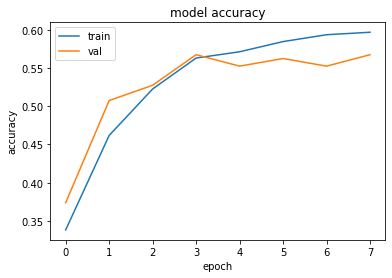

In [162]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

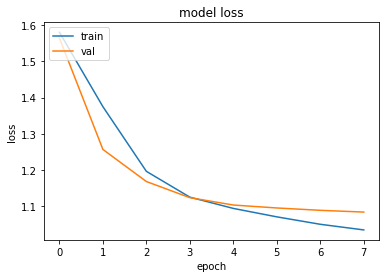

In [163]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [164]:
model.evaluate(test_padded, y_test)

25/25 [==============================] - 1s 6ms/step - loss: 1.0842 - accuracy: 0.5675


[1.0842065811157227, 0.5674999952316284]

In [165]:
def words_to_nums(input):
  training_sequences = tokenizer.texts_to_sequences(input)
  return pad_sequences(training_sequences, padding='post', maxlen=training_padded.shape[-1])

In [166]:
num_to_labels = {
    0:'anger',
    1:'fear',
    2:'joy',
    3:'love',
    4:'sadness',
    5:'surprise'
}

In [167]:
def get_prediction(text):
    text = tokenizer.texts_to_sequences([text])
    text = pad_sequences(text, padding='post', maxlen=training_padded.shape[-1])
    predict = model.predict(text)
    results = np.argmax(predict, axis=1)
    return num_to_labels[results[0]]

In [168]:
def play_game():
  print("enter 'stop' to end the session")
  user_input = 'start'
  while user_input!='stop':
    user_input = input('enter a sentence for the computer to guess the emotion [anger, fear, joy, love, sadness, surprise]:\n')
    if user_input!='stop':
      my_prediction = get_prediction(user_input)
      print('computer\'s guess is: ', my_prediction)




In [172]:
play_game()

enter 'stop' to end the session
enter a sentence for the computer to guess the emotion [anger, fear, joy, love, sadness, surprise]:
stop
